In [2]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)
library(ranger)
library(caret)

In [4]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [6]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
# final object for analysis:
df <- sd_to_df(pseq.clr) %>%
    select(cc, time, sample_id) %>%
    left_join(otus.clr, by = "sample_id") 

# next we randomly select 80% of each groups/timepoint as training data
ccpre <- df %>% filter(cc == "yes", time == "pre") %>% select(sample_id)
ccpost <- df %>% filter(cc == "yes", time == "post") %>% select(sample_id)
noccpre <- df %>% filter(cc == "no", time == "pre") %>% select(sample_id)
noccpost <- df %>% filter(cc == "no", time == "post") %>% select(sample_id)
# splitting
train_id <- c(
  sample(ccpre$sample_id, 39, replace = FALSE),
  sample(ccpost$sample_id, 39, replace = FALSE),
  sample(noccpre$sample_id, 39, replace = FALSE),
  sample(noccpost$sample_id, 39, replace = FALSE)
)
test_id <- df$sample_id[!df$sample_id %in% train_id]
# final object for analysis:
df_train <- df %>%
    filter(sample_id %in% train_id) %>%
    select(-sample_id) %>%
    group_by(time) %>%
    nest()
df_test <- df %>%
    filter(sample_id %in% test_id) %>%
    select(-sample_id) %>%
    group_by(time) %>%
    nest()   
df_train$data <- df_train$data %>% setNames(c("post", "pre"))
df_test$data <- df_test$data %>% setNames(c("post", "pre"))

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

In [7]:
# tune hyperparameters using grid_search 
hyper_grid <- expand.grid(
  mtry = seq(2, 130, by = 4),
  node_size = seq(1, 11, by =2),
  samp_size = c(0.55, 0.632, 0.7, 0.8)
)
hyper_grid$rn <- 1:nrow(hyper_grid)
hyper_grid <- hyper_grid %>% group_by(rn) %>% nest()

rf_ranger <- function(x, time = "pre") {
  model <- ranger(
    data = df_train$data[[time]],
    formula = cc ~ .,
    num.trees = 60000,
    mtry = x$mtry,
    min.node.size = x$node_size,
    sample.fraction = x$samp_size,
    importance = "impurity",
    probability = FALSE,
    keep.inbag = TRUE,
    seed = 123)
  return(model$prediction.error)
}
hyper_grid$oob_post <- map_dbl(hyper_grid$data, rf_ranger, "post")
hyper_grid$oob_pre <- map_dbl(hyper_grid$data, rf_ranger, "pre")

# what is the index of the model that resulted in lowest OOB?
post_id <- which.min(hyper_grid$oob_post)
pre_id <- which.min(hyper_grid$oob_pre)
hyper_grid$data[post_id]
hyper_grid$data[pre_id]
# what are the actual OOBs?
hyper_grid$oob_post[post_id]
hyper_grid$oob_pre[pre_id]

mtry,node_size,samp_size
2,3,0.55


mtry,node_size,samp_size
98,1,0.55


[1] 0.3974359

[1] 0.5128205

Ranger result

Call:
 ranger(data = .x, formula = cc ~ ., num.trees = 1e+05, mtry = hyper_grid$data[[.y]]$mtry,      min.node.size = hyper_grid$data[[.y]]$node_size, sample.fraction = hyper_grid$data[[.y]]$samp_size,      importance = "impurity", probability = FALSE, keep.inbag = TRUE,      ) 

Type:                             Classification 
Number of trees:                  1e+05 
Sample size:                      78 
Number of independent variables:  130 
Mtry:                             2 
Target node size:                 3 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             39.74 % 

Ranger result

Call:
 ranger(data = .x, formula = cc ~ ., num.trees = 1e+05, mtry = hyper_grid$data[[.y]]$mtry,      min.node.size = hyper_grid$data[[.y]]$node_size, sample.fraction = hyper_grid$data[[.y]]$samp_size,      importance = "impurity", probability = FALSE, keep.inbag = TRUE,      ) 

Type:                             Classification 
Number of trees:                  1e+05 
Sample size:                      78 
Number of independent variables:  130 
Mtry:                             98 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             53.85 % 

genus,.
Actinomycetaceae,0.12851176
Aerococcus,0.25650995
Aeromonas,0.04363512
Akkermansia,0.11911345
Alcaligenesfaecalisetrel,0.08581438
Allistipesetrel,0.13568870
Anaerobiospirillum,0.22609563
Anaerofustis,0.78411961
Anaerostipescaccaeetrel,0.46256503
Anaerotruncuscolihominisetrel,0.03284200


Selecting by importance
Selecting by importance


[[1]]

[[2]]


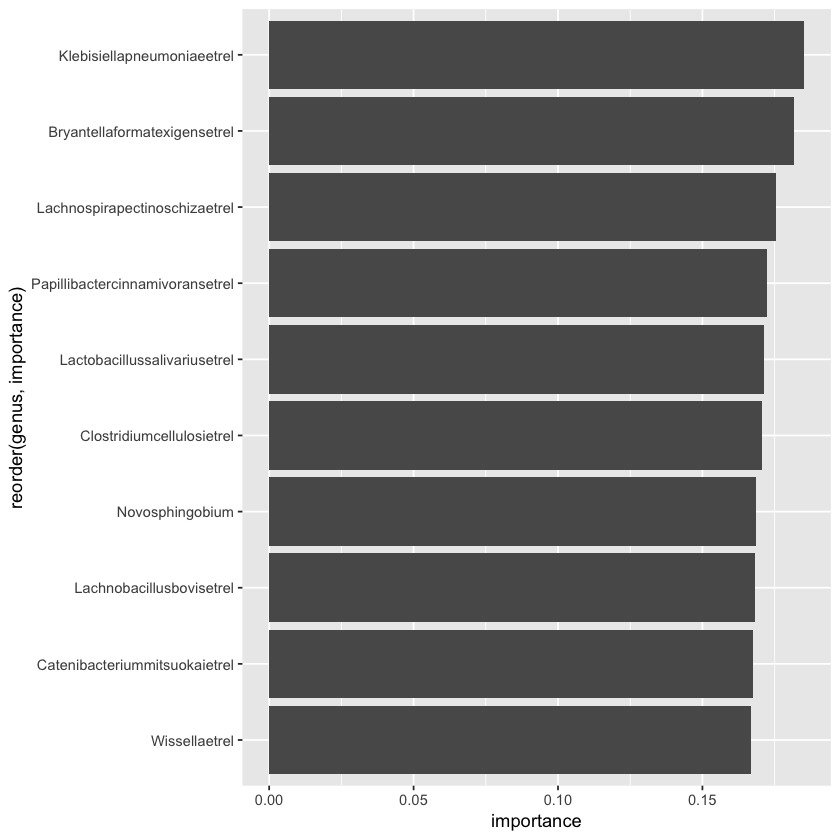

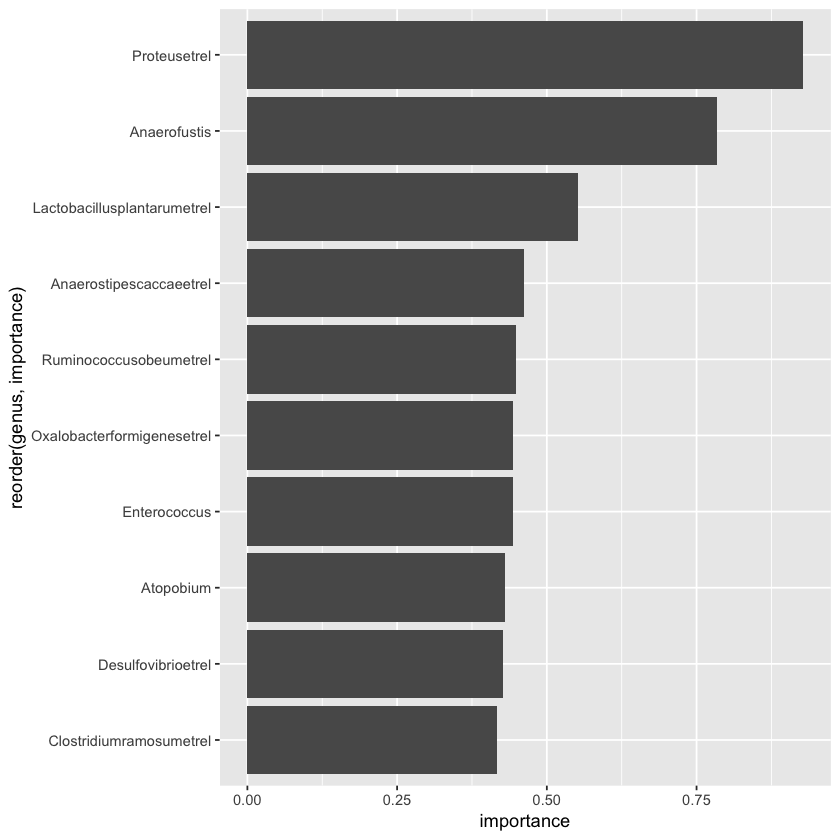

In [8]:
# fit models with the tuned parameters and we use high tree size
models <- map2(df_train$data, c(post_id, pre_id), ~ranger(
  data = .x,
  formula = cc ~ .,
  num.trees = 100000,
  mtry = hyper_grid$data[[.y]]$mtry,
  min.node.size = hyper_grid$data[[.y]]$node_size,
  sample.fraction = hyper_grid$data[[.y]]$samp_size,
  importance = "impurity",
  probability = FALSE,
  keep.inbag = TRUE,
))
models$post
imp_post <- models$post$variable.importance %>% 
  as.data.frame() %>%
  rownames_to_column("genus")
models$pre 
imp_pre <- models$pre$variable.importance %>% 
  as.data.frame() %>%
  rownames_to_column("genus")
imp_pre
map(list(imp_post, imp_pre), function(x){
  colnames(x) <- c("genus", "importance")
  x %>% arrange(desc(importance)) %>%
  top_n(10) %>%
  ggplot(aes(reorder(genus, importance), importance)) +
    geom_col() +
    coord_flip()
})

In [10]:
preds <- map2(
    .x = models, 
    .y = df_test$data, 
    ~predict(.x, data = .y))

In [11]:
cm <- map2(
    preds, 
    df_test$data,
    ~caret::confusionMatrix(
        data = .x$predictions,
        reference = .y$cc)
)

In [12]:
cm

$post
Confusion Matrix and Statistics

          Reference
Prediction no yes
       no   8   8
       yes  2   2
                                        
               Accuracy : 0.5           
                 95% CI : (0.272, 0.728)
    No Information Rate : 0.5           
    P-Value [Acc > NIR] : 0.5881        
                                        
                  Kappa : 0             
 Mcnemar's Test P-Value : 0.1138        
                                        
            Sensitivity : 0.8           
            Specificity : 0.2           
         Pos Pred Value : 0.5           
         Neg Pred Value : 0.5           
             Prevalence : 0.5           
         Detection Rate : 0.4           
   Detection Prevalence : 0.8           
      Balanced Accuracy : 0.5           
                                        
       'Positive' Class : no            
                                        

$pre
Confusion Matrix and Statistics

          Reference
Predicti

In [15]:
#save.image(file = here("data/cc_analyses_rf_half.RData"))

In [48]:
load(here("data/cc_analyses_rf_half.RData"))

In [16]:
#library(randomForest)
#rftest <- randomForest(
#    formula = cc ~.,
#    data = df_train$data$pre,
#    ntree = 50000
#)
#rftest

# Same for untransformed data to understand if/why results may differ

In [40]:
# rename genera
otus <- otu_to_df(pseq)
colnames(otus)[which(colnames(otus) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus) <- c("sample_id", gsub("_", "", colnames(otus)[-1]))
colnames(otus) <- gsub("\\.", "", colnames(otus))
colnames(otus) <- gsub(" ", "", colnames(otus))
# final object for analysis:
df2 <- sd_to_df(pseq) %>%
    select(cc, time, sample_id) %>%
    left_join(otus, by = "sample_id") 

# next we randomly select 80% of each groups/timepoint as training data
ccpre2 <- df2 %>% filter(cc == "yes", time == "pre") %>% select(sample_id)
ccpost2 <- df2 %>% filter(cc == "yes", time == "post") %>% select(sample_id)
noccpre2 <- df2 %>% filter(cc == "no", time == "pre") %>% select(sample_id)
noccpost2 <- df2 %>% filter(cc == "no", time == "post") %>% select(sample_id)
# splitting (since I use no seed the results will defnitively differ)
train_id <- c(
  sample(ccpre2$sample_id, 39, replace = FALSE),
  sample(ccpost2$sample_id, 39, replace = FALSE),
  sample(noccpre2$sample_id, 39, replace = FALSE),
  sample(noccpost2$sample_id, 39, replace = FALSE)
)
test_id <- df2$sample_id[!df2$sample_id %in% train_id]
# final object for analysis:
df_train2 <- df2 %>%
    filter(sample_id %in% train_id) %>%
    select(-sample_id) %>%
    group_by(time) %>%
    nest()
df_test2 <- df2 %>%
    filter(sample_id %in% test_id) %>%
    select(-sample_id) %>%
    group_by(time) %>%
    nest()   
df_train2$data <- df_train2$data %>% setNames(c("post", "pre"))
df_test2$data <- df_test2$data %>% setNames(c("post", "pre"))

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

In [42]:
# tune hyperparameters using grid_search 
hyper_grid2 <- expand.grid(
  mtry = seq(2, 130, by = 4),
  node_size = seq(1, 11, by =2),
  samp_size = c(0.55, 0.632, 0.7, 0.8)
)
hyper_grid2$rn <- 1:nrow(hyper_grid2)
hyper_grid2 <- hyper_grid2 %>% group_by(rn) %>% nest()

rf_ranger2 <- function(x, time = "pre") {
  model <- ranger(
    data = df_train2$data[[time]],
    formula = cc ~ .,
    num.trees = 60000,
    mtry = x$mtry,
    min.node.size = x$node_size,
    sample.fraction = x$samp_size,
    importance = "impurity",
    probability = FALSE,
    keep.inbag = TRUE,
    seed = 123)
  return(model$prediction.error)
}
hyper_grid2$oob_post <- map_dbl(hyper_grid2$data, rf_ranger2, "post")
hyper_grid2$oob_pre <- map_dbl(hyper_grid2$data, rf_ranger2, "pre")

# what is the index of the model that resulted in lowest OOB?
post_id2 <- which.min(hyper_grid2$oob_post)
pre_id2 <- which.min(hyper_grid2$oob_pre)
hyper_grid2$data[post_id]
hyper_grid2$data[pre_id]
# what are the actual OOBs?
hyper_grid2$oob_post[post_id]
hyper_grid2$oob_pre[pre_id]

mtry,node_size,samp_size
2,3,0.55


mtry,node_size,samp_size
98,1,0.55


[1] 0.5769231

[1] 0.6410256

Ranger result

Call:
 ranger(data = .x, formula = cc ~ ., num.trees = 1e+05, mtry = hyper_grid2$data[[.y]]$mtry,      min.node.size = hyper_grid2$data[[.y]]$node_size, sample.fraction = hyper_grid2$data[[.y]]$samp_size,      importance = "impurity", probability = FALSE, keep.inbag = TRUE,      ) 

Type:                             Classification 
Number of trees:                  1e+05 
Sample size:                      78 
Number of independent variables:  130 
Mtry:                             58 
Target node size:                 11 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             50.00 % 

Ranger result

Call:
 ranger(data = .x, formula = cc ~ ., num.trees = 1e+05, mtry = hyper_grid2$data[[.y]]$mtry,      min.node.size = hyper_grid2$data[[.y]]$node_size, sample.fraction = hyper_grid2$data[[.y]]$samp_size,      importance = "impurity", probability = FALSE, keep.inbag = TRUE,      ) 

Type:                             Classification 
Number of trees:                  1e+05 
Sample size:                      78 
Number of independent variables:  130 
Mtry:                             2 
Target node size:                 1 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error:             56.41 % 

genus,.
Actinomycetaceae,0.1895207
Aerococcus,0.1834386
Aeromonas,0.1559735
Akkermansia,0.1663691
Alcaligenesfaecalisetrel,0.1705860
Allistipesetrel,0.1939744
Anaerobiospirillum,0.1801928
Anaerofustis,0.2072072
Anaerostipescaccaeetrel,0.1677841
Anaerotruncuscolihominisetrel,0.1762485


Selecting by importance
Selecting by importance


[[1]]

[[2]]


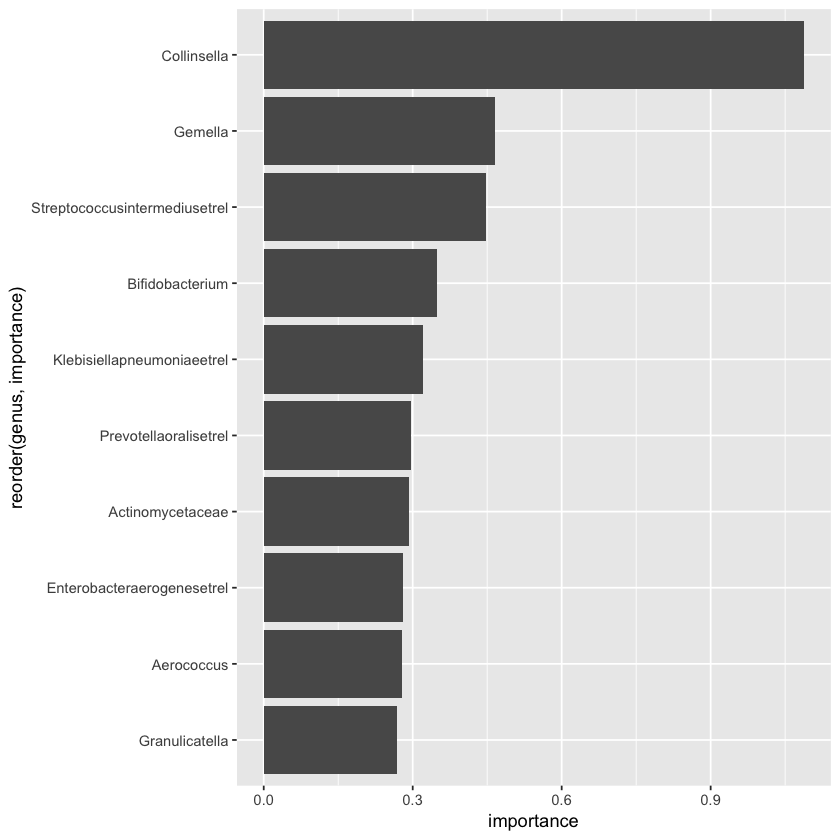

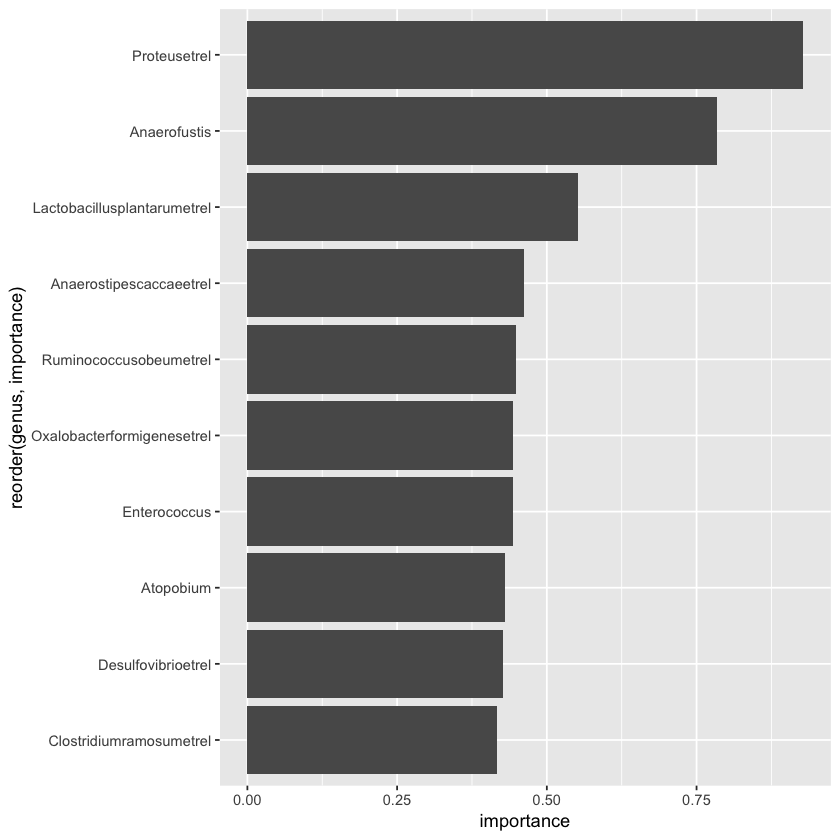

In [43]:
# fit models with the tuned parameters and we use high tree size
models2 <- map2(df_train2$data, c(post_id2, pre_id2), ~ranger(
  data = .x,
  formula = cc ~ .,
  num.trees = 100000,
  mtry = hyper_grid2$data[[.y]]$mtry,
  min.node.size = hyper_grid2$data[[.y]]$node_size,
  sample.fraction = hyper_grid2$data[[.y]]$samp_size,
  importance = "impurity",
  probability = FALSE,
  keep.inbag = TRUE,
))
models2$post
imp_post2 <- models2$post$variable.importance %>% 
  as.data.frame() %>%
  rownames_to_column("genus")
models2$pre 
imp_pre2 <- models2$pre$variable.importance %>% 
  as.data.frame() %>%
  rownames_to_column("genus")
imp_pre2
map(list(imp_post2, imp_pre), function(x){
  colnames(x) <- c("genus", "importance")
  x %>% arrange(desc(importance)) %>%
  top_n(10) %>%
  ggplot(aes(reorder(genus, importance), importance)) +
    geom_col() +
    coord_flip()
})

In [44]:
preds2 <- map2(
    .x = models2, 
    .y = df_test2$data, 
    ~predict(.x, data = .y))

In [45]:
cm <- map2(
    preds2, 
    df_test2$data,
    ~caret::confusionMatrix(
        data = .x$predictions,
        reference = .y$cc)
)

In [52]:
cm$post

Confusion Matrix and Statistics

          Reference
Prediction no yes
       no   8   8
       yes  2   2
                                        
               Accuracy : 0.5           
                 95% CI : (0.272, 0.728)
    No Information Rate : 0.5           
    P-Value [Acc > NIR] : 0.5881        
                                        
                  Kappa : 0             
 Mcnemar's Test P-Value : 0.1138        
                                        
            Sensitivity : 0.8           
            Specificity : 0.2           
         Pos Pred Value : 0.5           
         Neg Pred Value : 0.5           
             Prevalence : 0.5           
         Detection Rate : 0.4           
   Detection Prevalence : 0.8           
      Balanced Accuracy : 0.5           
                                        
       'Positive' Class : no            
                                        

In [47]:
save.image(file = here("data/cc_analyses_rf_secondhalf.RData"))